In [24]:
# Mik
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import allego_file_reader as afr 
import spikeinterface as si
import spikeinterface.widgets as sw
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.extractors as se 
import spikeinterface.postprocessing as spost
import spikeinterface.exporters as sexp
import probeinterface as pi
import warnings, sys
warnings.simplefilter("ignore")
%matplotlib inline
from pathlib import Path
import os

print(f"SpikeInterface version: {si.__version__}")

# Define the root folder
# The root folder should contain all the data of a single session: raw+curated, preprocessed/filtered and spike-sorted 
root = 'G:/NN_data/SNA-128477/ephys/'
raw_folder = root + 'raw/' 
# np.set_printoptions(threshold=sys.maxsize)

# In the raw folder find all .xdat.json files
raw_path = Path(raw_folder)
all_xdat_filesnames = [Path(elem.stem).stem for elem in list(raw_path.glob('**/*xdat.json'))]
print(f'XDAT filenames in folder: {all_xdat_filesnames}')

# From the print above pick a file, I go for 'allego_0__uid0212-13-53-48' and read its metadata
target_file = raw_folder + all_xdat_filesnames[0] 
metadata = afr.read_allego_xdat_metadata(target_file)
signals, timestamps, time_samples = afr.read_allego_xdat_all_signals(target_file)
print(f'LOADED: {target_file}')

SpikeInterface version: 0.99.1
XDAT filenames in folder: ['allego_0__uid0212-13-53-48', 'allego_0__uid0213-13-47-02', 'allego_0__uid0214-13-48-46', 'allego_1__uid0215-14-48-34']
LOADED: G:/NN_data/SNA-128477/ephys/raw/allego_0__uid0212-13-53-48


In [25]:
from scipy.signal import butter, filtfilt

# One pulse is 200 ms or 0.2s that means 0.2* samplefrequency (fSample) datapoints
fSample = 30000
TTL_duration = int(0.2 * fSample)

# Find the Analog IN 1 channel in the singals
np.set_printoptions(threshold=sys.maxsize)

def getStim_idx(signals):
    ''' Takes the .xdat allego file, reads channel 32 (Analog IN) and determines where the TTL pulse that triggers microstim starts
    '''
    # Select the AI1 channel
    ain_signal = signals[32]
    if any(ain_signal >= 4):
        TTL_idx = np.where(np.diff(ain_signal) >= 2)[0]+1 # +1 gives us the start of the trigger
    else:
        TTL_idx = False
    return TTL_idx

def get_periStim(signals, order=False, limit=10, start_time=0.5, stop_time=2):
    '''docstring
    '''
    # From signals get the TTL indexes of the stimuli
    TTL_idx = getStim_idx(signals)
    print(TTL_idx.shape)
    print(type(TTL_idx))
    if limit == False:
        limit = len(TTL_idx)   
    TTL_idx = TTL_idx[0:limit] # TODO what if you want to limit the view to the middle or the end?


    # Create a dataframe where each row refers to a stimulus and has a array of voltage values
    periStim_df = pd.DataFrame(index=range(limit), columns=['signal'])
    periStim_df['signal'] = periStim_df['signal'].apply(lambda x: {})
    
    # Go through all stimuli, snip the signal for each channel and 
    for i, TTL in enumerate(TTL_idx):
        periStim_data = periStim_df['signal'].iloc[i]   

        # Snip the signal 0.5s before and 2s after stimulus
        start = int(TTL-start_time*fSample)
        stop = int(TTL+stop_time*fSample)
        nChannels=16
        nSamples = stop-start

        # If you want the signals order in the dictionary determine the order based on channel_idx
        if order == False:
            for i, signal in enumerate(signals[0:nChannels]):
                periStim_signal = signals[i][start:stop] # TODO only one channel # i is the channel start stop the snippet
                periStim_data[i] = periStim_signal

        elif isinstance(order, list):
            for i in order:
                periStim_signal = signals[i-1][start:stop] # -1 because the order is in channel index which starts from 1
                periStim_data[i] = periStim_signal 

        # TODO check order input 
                
        periStim_df['signal'][i] = periStim_data
    return periStim_df

# Now we try with a filtered signal
def common_average_referencing(data, nChannel=16):
    '''docsting
    '''
    # Calculate the average across all channels
    average_across_priChannels = np.mean(data[0:nChannel], axis=0)

    # Subtract the average from each channel
    car_data_priChannels = data[0:nChannel] - average_across_priChannels

    # Now add the normal channels back again
    car_data = np.vstack((car_data_priChannels, data[nChannel:]))
    return car_data

def bandpass_filter(data, lowcut, highcut, fs, nChannels=16, order=4):
    rec_data = data[0:nChannels]

    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    # Design bandpass filter
    b, a = butter(order, [low, high], btype='band')

    # Apply bandpass filter to recording channels
    filtered_recdata = filtfilt(b, a, rec_data, axis=1)

    # Concatenate the filtered recordning channels with the analog and digital ones
    filtered_data = np.vstack((filtered_recdata, data[nChannels:]))
    return filtered_data

def createProbe(metadata):
    '''docstring'''
    # TODO: Shank_ids, and radius have to be extracted from the meta file in stead of hardcoded.

    # Now that we have loaded the metadata, extract the probe information from this file
    # Probe information needed (for Kilosort3) = chanMap, chanMap0ind, connected, kcoords, name, xcoords and ycoords
    # What I think is needed in Spikeinterface for probeinterface based on tutorials and example NN probe: contact positions, plane axes? shapes, shape params (radius), planar contour

    # First we get essential probe information
    # Get nChannel for off incorrect channels, specifying shank ID 
    nChannel = metadata['sapiens_base']['sensors_by_port']['A']['num_channels']

    # SamplingFrequency
    fSample = metadata['status']['samp_freq']

    # Positions
    xcoords = metadata['sapiens_base']['biointerface_map']['site_ctr_tcs_x']
    ycoords = [abs(y) for y in metadata['sapiens_base']['biointerface_map']['site_ctr_tcs_y']]
    positions = [(x,y) for x,y in zip(xcoords, ycoords)] 

    # ProbeName 
    probeName_raw = metadata['sapiens_base']['sensors_by_port']['A']['probe_id']
    probeName = probeName_raw.split('__')[1]

    # Units
    si_units = metadata['sapiens_base']['biointerface_map']['sensor_units'][0]

    # Now we create a probe object with ndim2 since it is a linear probe
    probe = pi.Probe(ndim=2, si_units=si_units, name=probeName, manufacturer='NeuroNexus') # TODO where is the serialnumber in the metafile? maybe do manually?
    probe.set_contacts(positions=positions[0:nChannel], shapes='circle', shape_params={'radius':50}, shank_ids=np.zeros(nChannel, dtype=int), contact_ids=np.arange(1,nChannel+1,1))
    probe.set_device_channel_indices(np.arange(0, nChannel, 1))
    return probe

probe = createProbe(metadata)
probe_df = probe.to_dataframe()
display(probe_df)
channel_order = probe_df.sort_values(by='y', ascending=True)['contact_ids'].astype(int).to_list()

,x,y,contact_shapes,radius,shank_ids,contact_ids
0,32.25,376.5,circle,50.0,0,1
1,32.25,416.5,circle,50.0,0,2
2,32.25,656.5,circle,50.0,0,3
3,32.25,496.5,circle,50.0,0,4
4,32.25,456.5,circle,50.0,0,5
5,32.25,616.5,circle,50.0,0,6
6,32.25,536.5,circle,50.0,0,7
7,32.25,576.5,circle,50.0,0,8
8,32.25,136.5,circle,50.0,0,9
9,32.25,176.5,circle,50.0,0,10


# Create PSTS
For every stimulus:
- get the response of the channels
- order the channels
- Plot the raw response 
- PLot the filtered response
Ideally a plot with 3 columns and 16 rows where each row is a channel and each column is

In [26]:
# Get peri Stim dataframe on raw, CAR and filtered signal
print('Applying filters')
CAR_signals = common_average_referencing(signals)
filt_signals = bandpass_filter(CAR_signals, lowcut=300, highcut=5000, fs=fSample)
print('Done!')



Applying filters
Done!


In [27]:
raw_periStim_df = get_periStim(signals, order=channel_order, limit=False, start_time=0.5, stop_time=2) 
CAR_periStim_df = get_periStim(CAR_signals, order=channel_order, limit=False, start_time=0.5, stop_time=2) 
filt_periStim_df = get_periStim(filt_signals, order=channel_order, limit=False, start_time=0.5, stop_time=2)

(88,)
<class 'numpy.ndarray'>
(88,)
<class 'numpy.ndarray'>
(88,)
<class 'numpy.ndarray'>


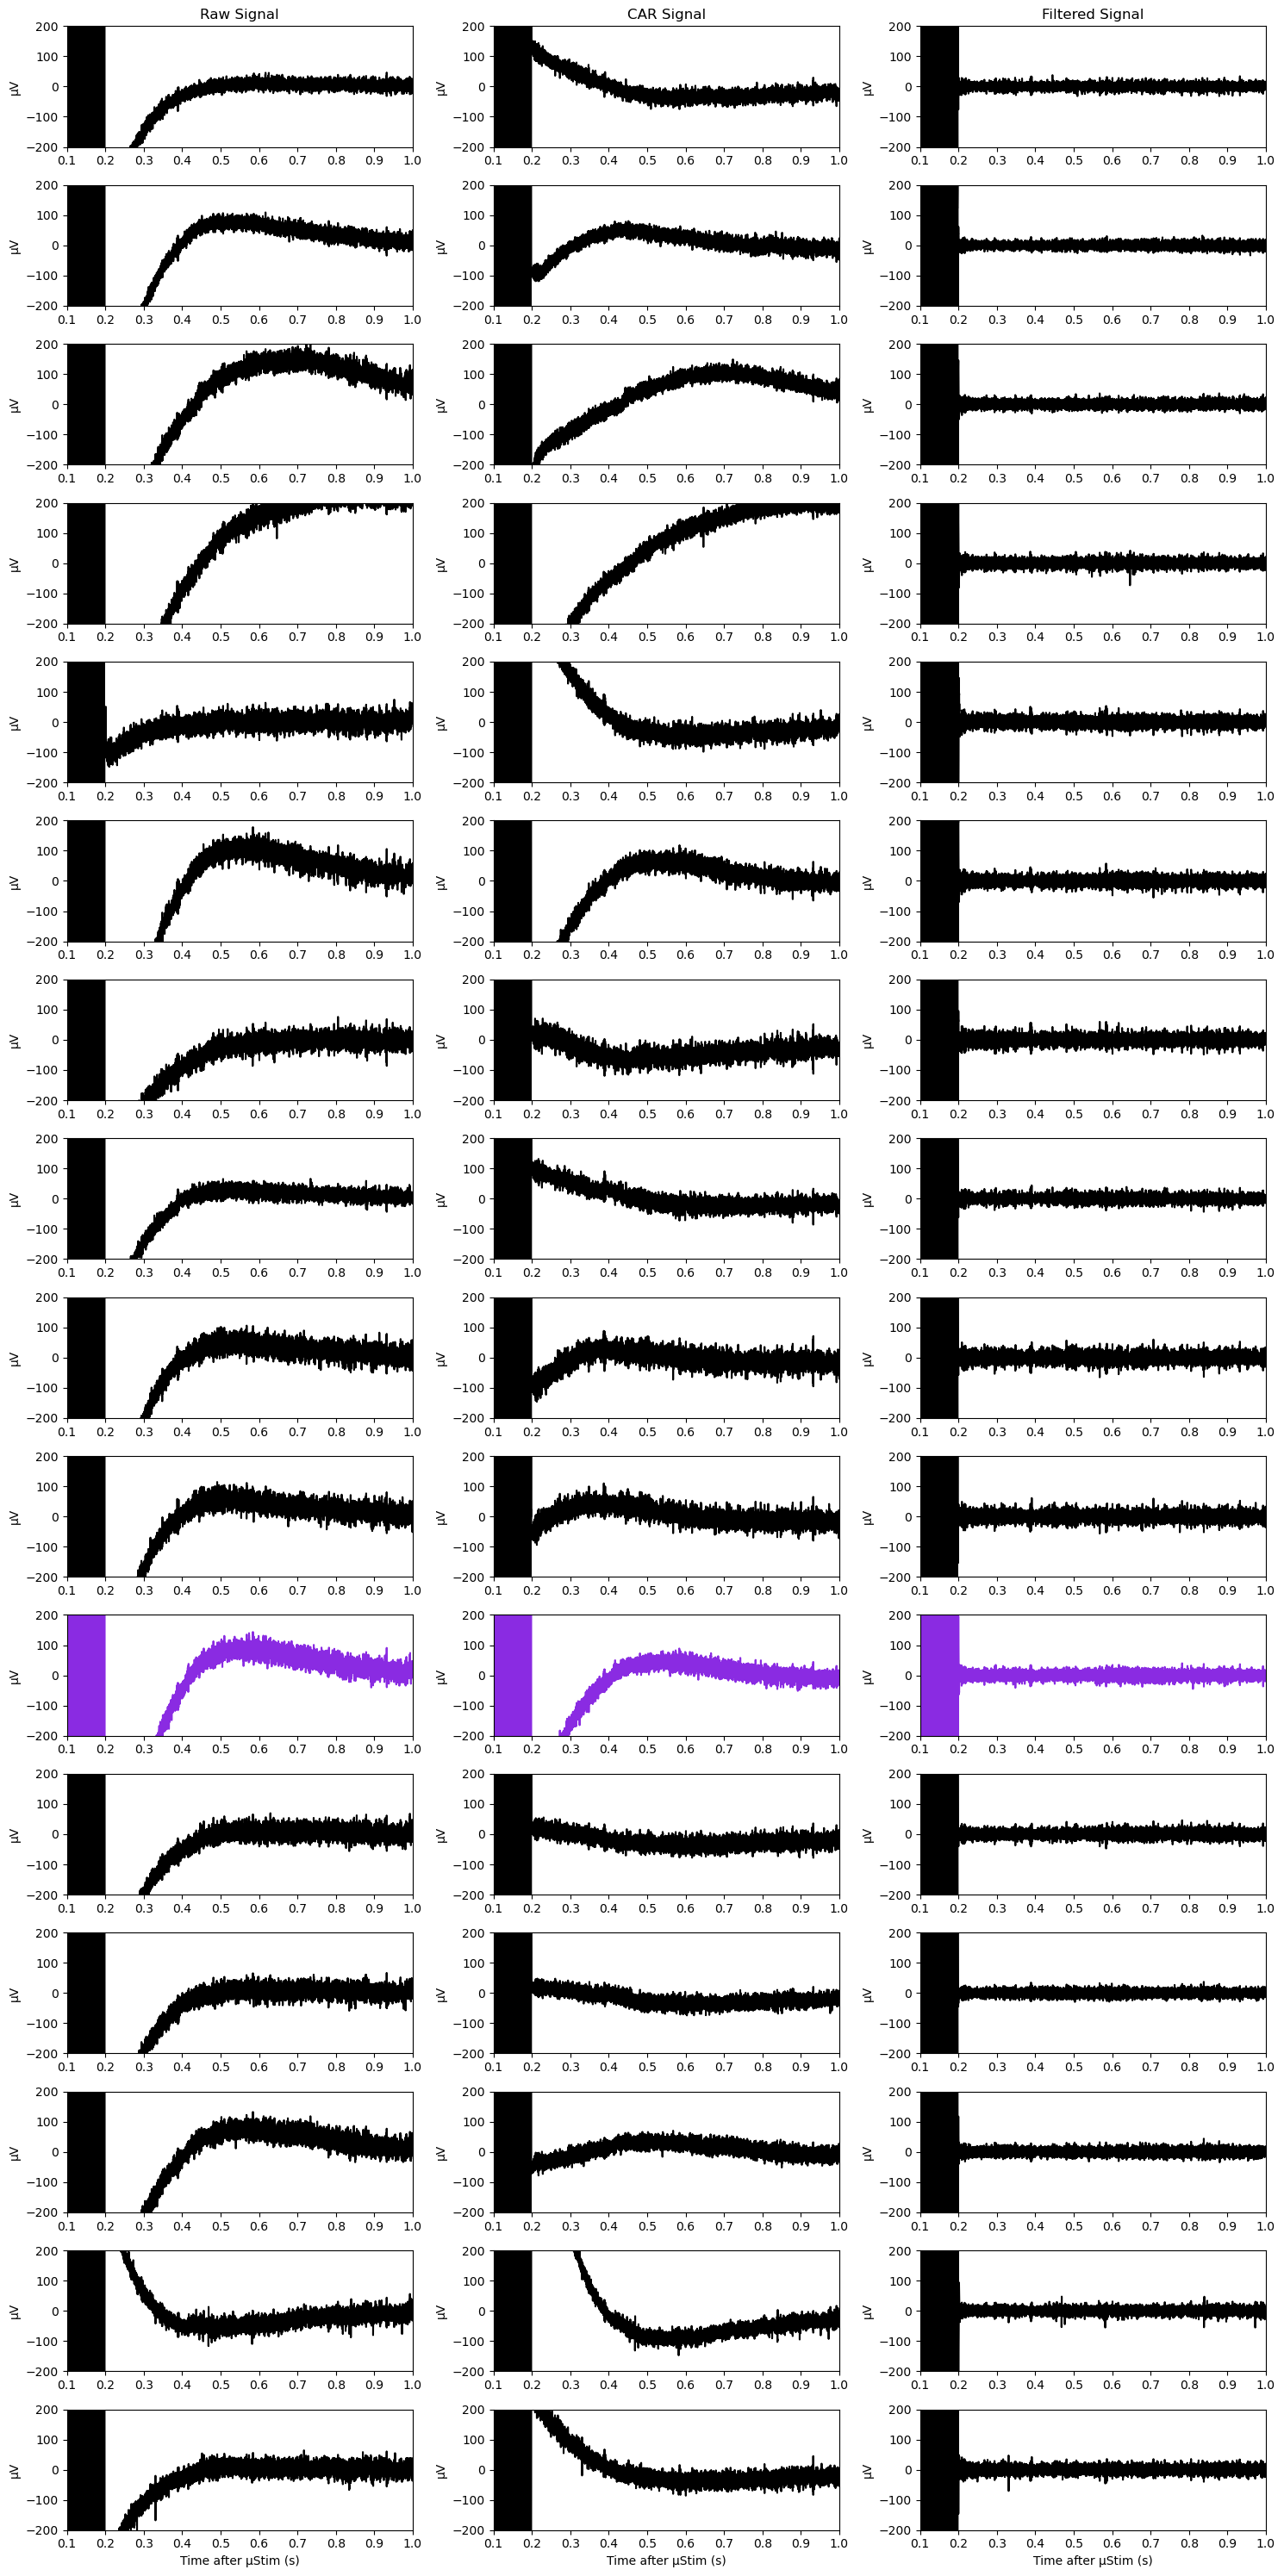

In [28]:
def plot_signals(ax, periStim, title, time=(-0.5, 2), stimChannel=5):
    '''
    Plots signals in a 16x3 grid of subplots.

    Parameters:
    - ax: AxesSubplot
        The subplots to be used for plotting.
    - periStim: dict
        Dictionary containing signal data for each channel.
    - title: str
        Title for the entire column.
    - time: tuple, optional
        Tuple specifying the time range for the x-axis. Default is (-0.5, 2).
    '''
    i = 0 # This keeps track of where to place the trace
    for channel_idx in periStim.keys(): # Should be a value that corresponds to the channel index i.e. 1 till 16 for 16channel probe
        # Set color for highlighting stimulating channel
        if channel_idx == stimChannel: 
            traceColor = 'blueviolet'
        else:
            traceColor = 'black'
        
        # Plot
        time_values_s = np.linspace(-0.5, 2, len(periStim[channel_idx]))
        ax[i].plot(time_values_s, periStim[channel_idx], label=f'Channel {channel_idx}', color=traceColor)
        ax[i].axvline(0, color='red', linestyle='--')
        ax[i].set_xlim(time[0], time[1])
        ax[i].set_ylim(-200, 200)
        ax[i].set_ylabel('\u03BCV')
        i+=1
    ax[0].set_title(title)
    ax[-1].set_xlabel('Time after \u03BCStim (s)')

def create_periStim_grid(periStim_dfs, stim_idx, time=(-0.5, 2), figsize=(15, 30)):
    '''
    Creates a 16x3 grid of subplots and plots signals for each column.

    Parameters:
    - periStim_dfs: list of dict
        List containing dictionaries of signal data for each condition.
    - time: tuple, optional
        Tuple specifying the time range for the x-axis. Default is (-0.5, 2).
    - figsize: tuple, optional
        Tuple specifying the size of the figure. Default is (15, 30).
    '''
    # Create a 16x3 grid of subplots
    fig, axs = plt.subplots(nrows=16, ncols=3, figsize=figsize)

    # Plot signals for each condition in the corresponding column
    titels = ['Raw', 'CAR', 'Filtered']
    for i, periStim_df in enumerate(periStim_dfs):
        plot_signals(axs[:, i], periStim_df['signal'].iloc[stim_idx], f'{titels[i]} Signal', time)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

all_periStim_dfs = [raw_periStim_df, CAR_periStim_df, filt_periStim_df]
# create_periStim_grid(all_periStim_dfs, stim_idx=0) # Normal
create_periStim_grid(all_periStim_dfs, stim_idx=12, time=(0.1, 1)) # Zoomed


# Arbitrarily detect spikes
- Get the variance of the signal from the mean
- Visualise the mean plus minus this variance and determine if that is an alright threshold
- For each point that goes above theshold count it as a spike
    - Make sure that a spike is not counted twice so skip a certain range after a spike is counted

# Considerations
- Should I take the std from the time before stimulus onset?

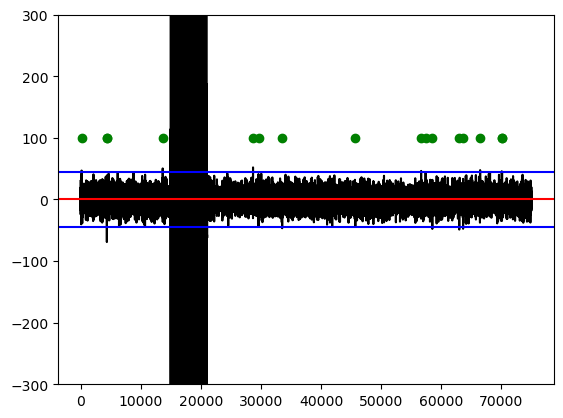

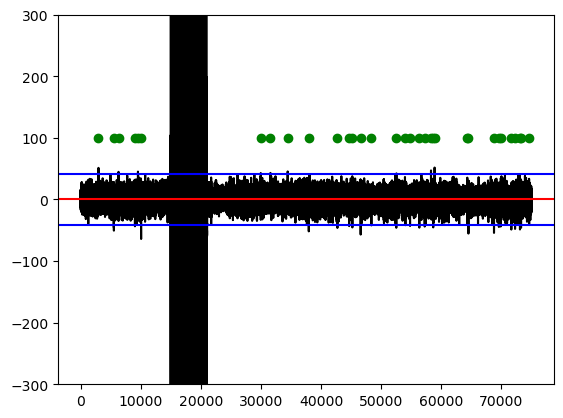

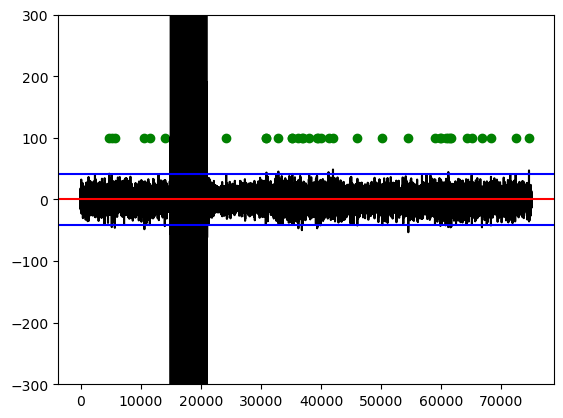

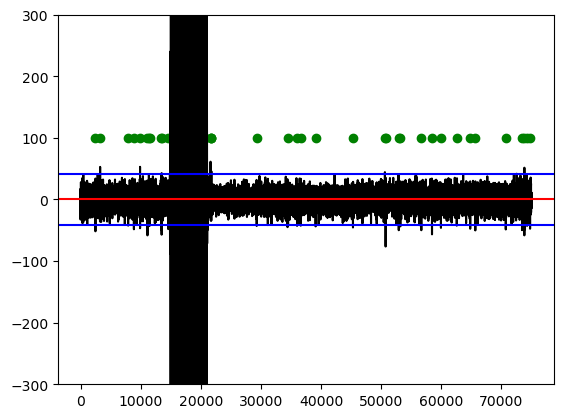

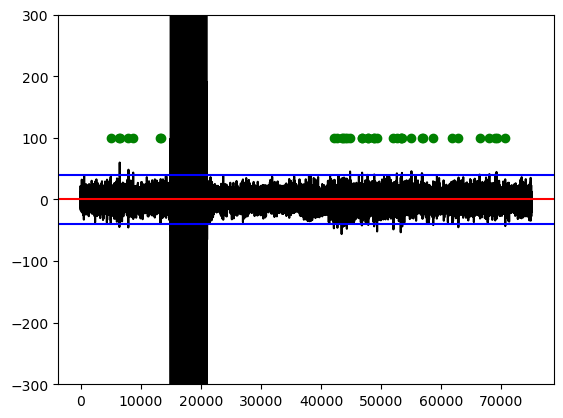

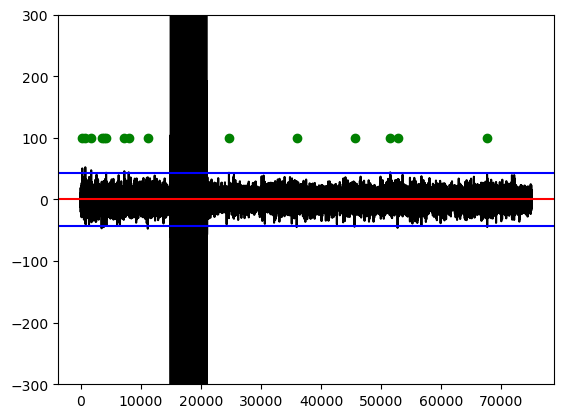

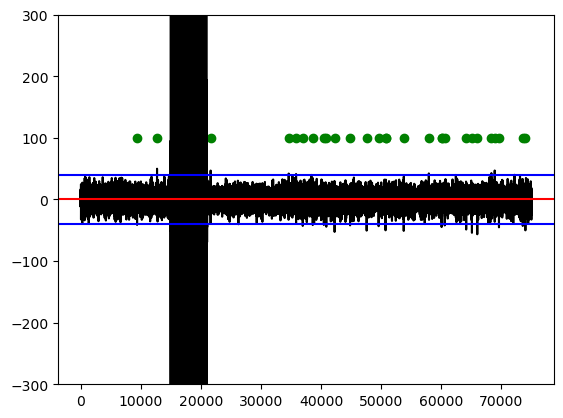

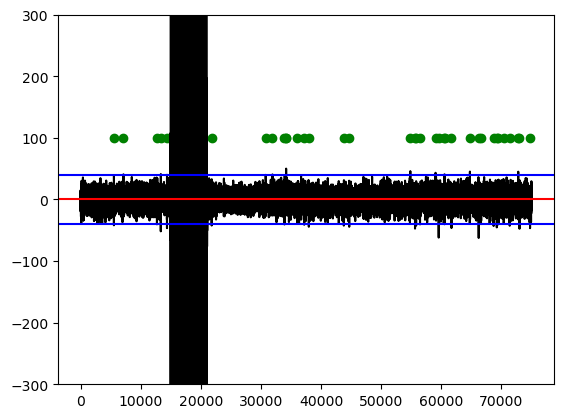

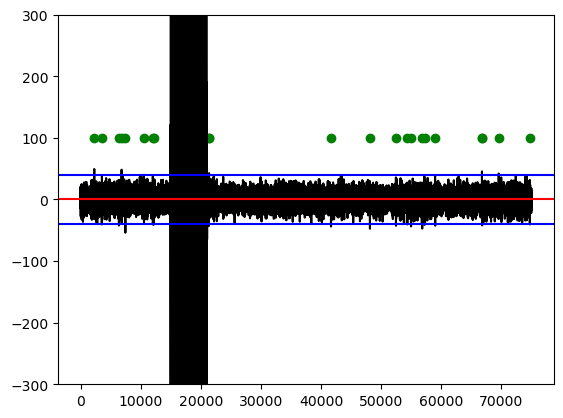

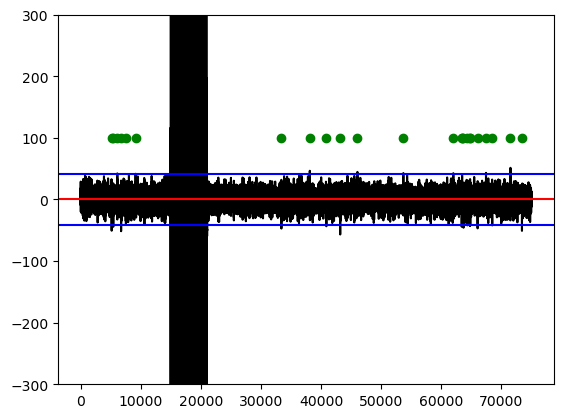

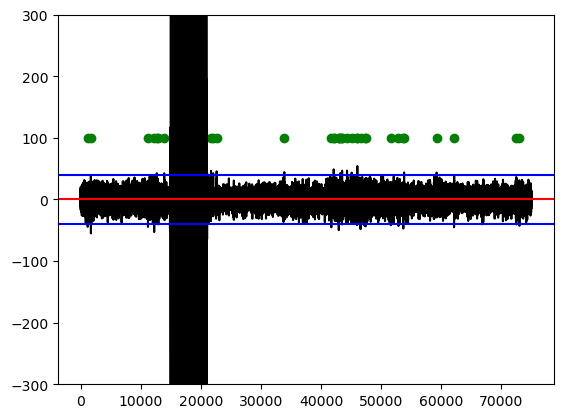

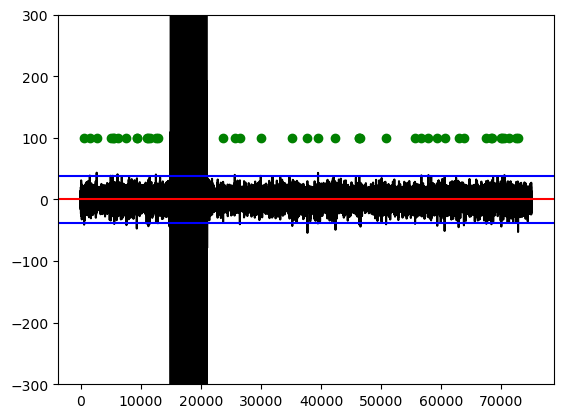

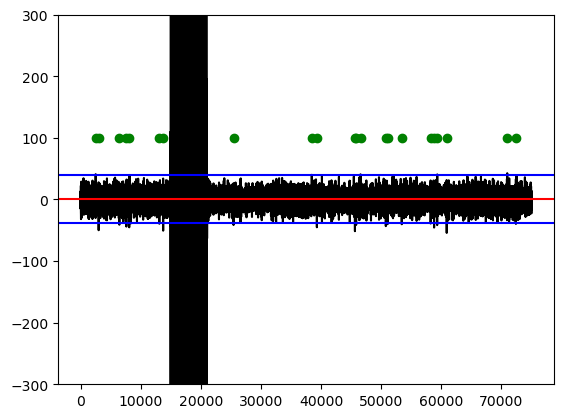

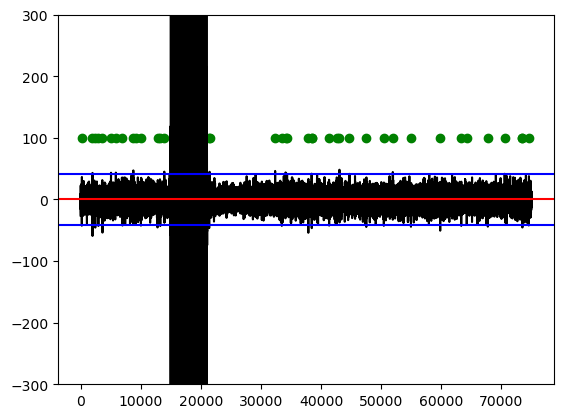

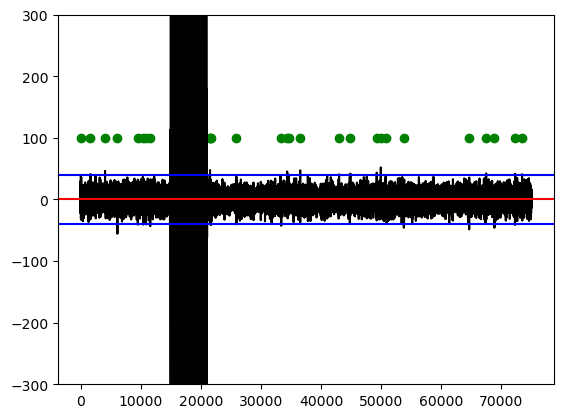

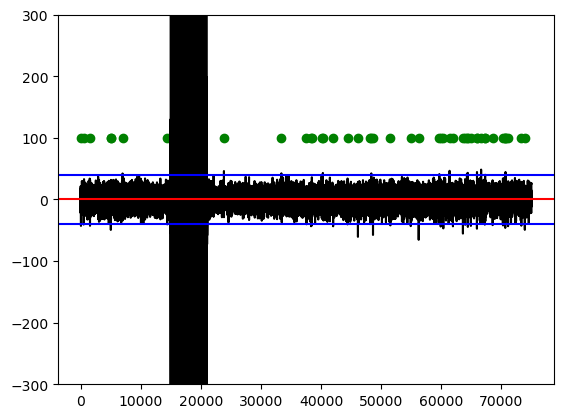

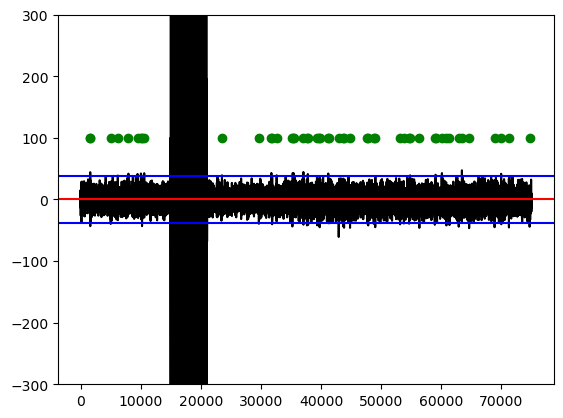

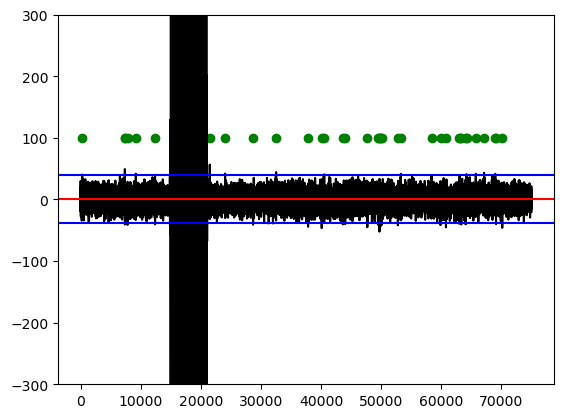

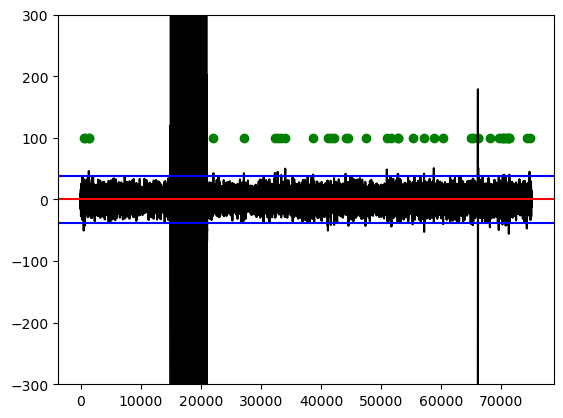

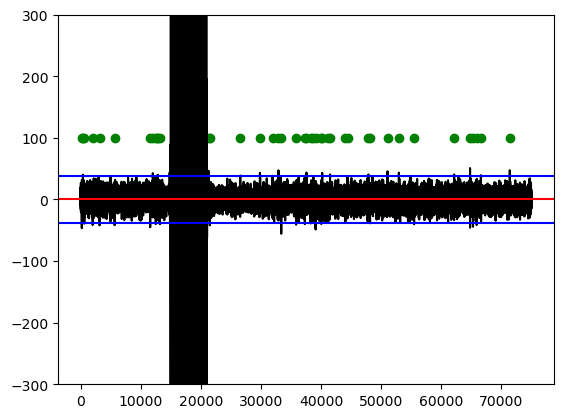

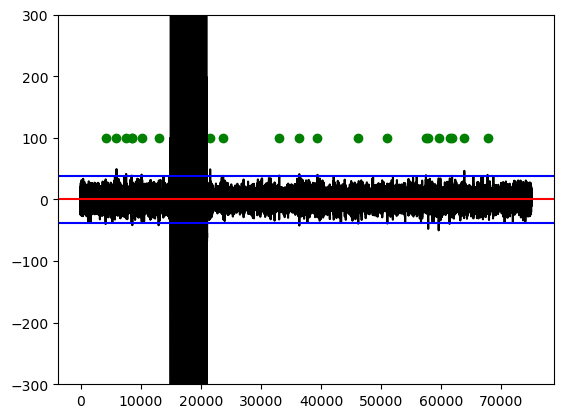

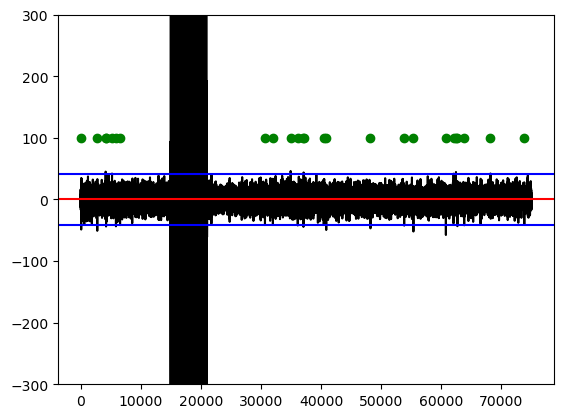

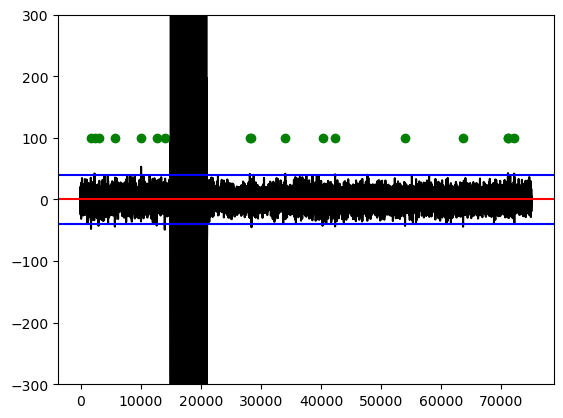

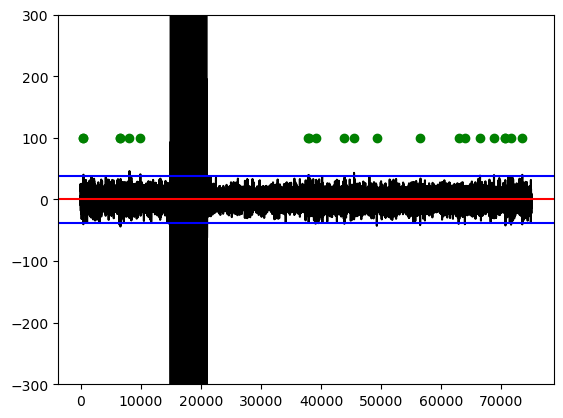

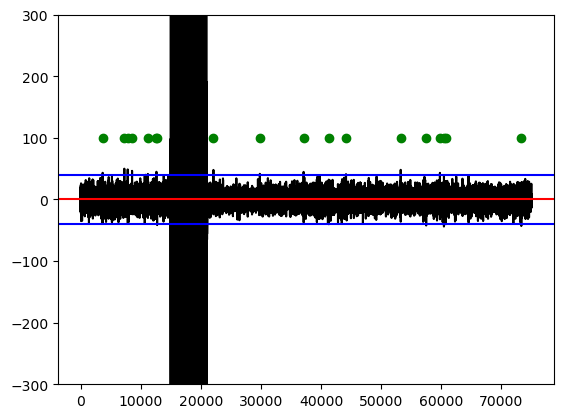

In [29]:
def detect_spikes(single_trace, fSample=30000, threshold_multiplier=3, window_size_ms=2, stim_window=[0.5, 0.7]):
    """
    Detect spikes in a single trace.

    Parameters:
    - single_trace: 1D numpy array, representing the neural signal trace.
    - fSample: Sampling frequency of the signal.
    - threshold_multiplier: Multiplier for determining the threshold.
    - window_size_ms: Size of the window for marking the first occurrence of each spike (in milliseconds).

    Returns:
    - spikes_first_occurrence: 1D numpy array, marking the first occurrence of each spike within the specified window.
    """
    # Get stim window
    stim_start_t = stim_window[0] - 0.01 
    stim_end_t = stim_window[1] + 0.01
    stim_start = int(stim_start_t * fSample)
    stim_end = int(stim_end_t * fSample)

    # Calculate mean and standard deviation of the pre-stimulus period
    pre_stim = int(stim_start)
    signal_mean = np.mean(single_trace[0:pre_stim])
    signal_std = np.std(single_trace[0:pre_stim])

    # Determine threshold values
    threshold_pos = signal_mean + (threshold_multiplier * signal_std)
    threshold_neg = signal_mean - (threshold_multiplier * signal_std)

    # Count threshold crosses
    spikes_pos = single_trace > threshold_pos
    spikes_neg = single_trace < threshold_neg
    spikes = spikes_pos | spikes_neg

    # Remove spikes that were counted during the stimulus
    spikes[stim_start:stim_end] = [False] * (stim_end - stim_start)

    # Create a new array to mark only the first occurrence of each spike within a window
    window_size = int(fSample * (window_size_ms / 1000))  # Convert window size to samples
    spikes_first_occurrence = np.zeros_like(spikes)

    for i in range(0, len(spikes), window_size):
        if np.any(spikes[i:i + window_size]):
            first_spike_index = i + np.argmax(spikes[i:i + window_size])
            spikes_first_occurrence[first_spike_index] = True

    return {'spikes':spikes_first_occurrence, 'mean':signal_mean, 'std':signal_std, 'threshold':(threshold_neg, threshold_pos)}

# Plot
ii = np.arange(20,50,1)
ii = [0,73]
ii = np.arange(0,25,1)
for i in ii:
    single_trace = filt_periStim_df['signal'].iloc[i][5]

    spike_dict = detect_spikes(single_trace, threshold_multiplier=3.5)
    spikes_first_occurrence= spike_dict['spikes']

    signal_mean = spike_dict['mean']
    threshold_neg, threshold_pos = spike_dict['threshold']

    # See what it looks like
    plt.plot(single_trace, color='black')
    plt.axhline(signal_mean, color='red')
    plt.axhline(threshold_pos, color='blue')
    plt.axhline(threshold_neg, color='blue')
    plt.ylim(-300, 300)
    plt.scatter(np.where(spikes_first_occurrence)[0], np.full_like(np.where(spikes_first_occurrence)[0], 100), color='green', label='Spikes')
    plt.show()

# Making a raster plot of the spiketimes 
- For every stimulus
- Get the spiketimes
- plot is as a row

(88,)
<class 'numpy.ndarray'>


,signal
0,"{14: [-12.336450275520303, -12.444453256549135..."
1,"{14: [0.5471768319643157, -1.3048716633688002,..."
2,"{14: [4.396382411130538, 5.208947827491967, 2...."
3,"{14: [-0.31068596443378693, 4.934922913796771,..."
4,"{14: [3.5411625540839458, 2.401640573810102, -..."
...,...
83,"{14: [2.8061435076207752, 8.538005822526642, 1..."
84,"{14: [-1.9166989949296287, -0.5978615022761391..."
85,"{14: [-6.555472477574565, -10.092208924942788,..."
86,"{14: [-7.25420520769645, -6.68415197381966, -6..."


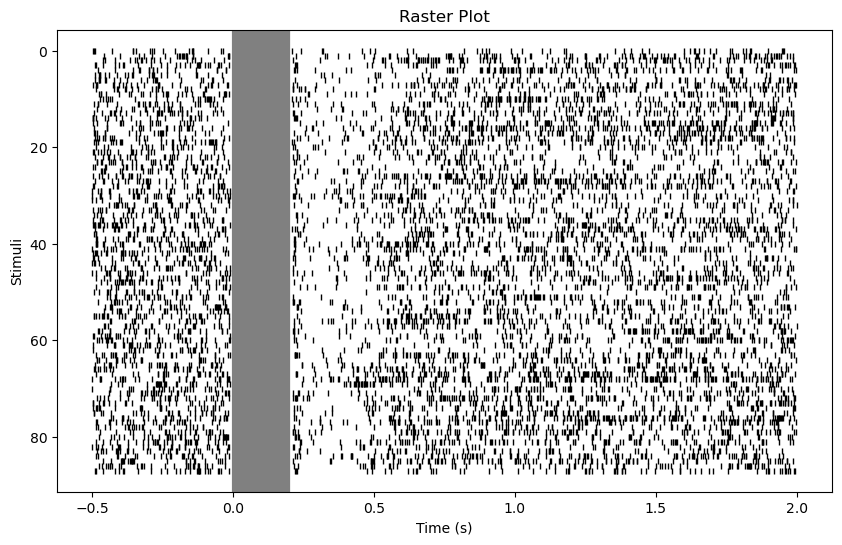

In [30]:
# Make the full perstim dataframe
full_filt_peristim_df = get_periStim(filt_signals, order=channel_order, limit=False)
display(full_filt_peristim_df)

#TODO Divide into deep, middle and superficial layers
# first pass get the stimulating channel
spike_array = []
for signal in full_filt_peristim_df['signal']:
    stimsignal = signal[5] # Select only the stimulating channel

    # Get the number of spikes
    signalSpike_dict = detect_spikes(stimsignal)
    signalSpikes = signalSpike_dict['spikes']
    spike_array.append(signalSpikes)

def plot_raster(boolean_matrix, fSample=30000):
    ''' input needs to be a spike matrix where each row is a stimulus and each column is a timepoint
    plots a spike raster of all threshold spikes during the peristim time.
    '''
    spikes_x, spikes_y = np.where(boolean_matrix)

    plt.figure(figsize=(10, 6))
    plt.plot((spikes_y / fSample)-0.5, spikes_x, '|', color='black', markersize=5)
    plt.xlabel('Time (s)')
    plt.ylabel('Stimuli')
    plt.title('Raster Plot')
    plt.gca().invert_yaxis()  # Invert y-axis to have the first row at the top
    [plt.axvline(i, color='gray', label='Stimulus') for i in np.arange(0, 0.2, 0.001)]
    plt.show()

# Example usage:
plot_raster(np.array(spike_array))
# TODO get drift trace

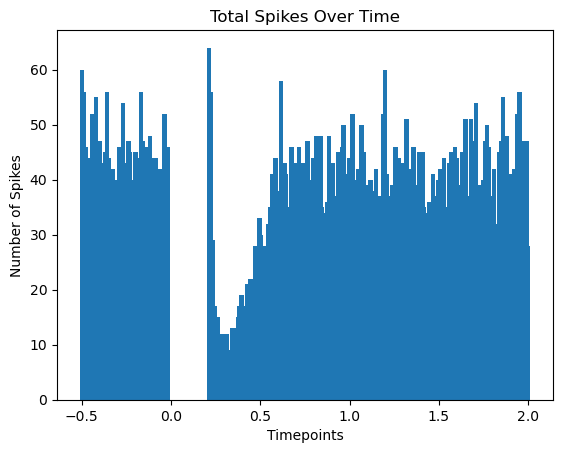

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the average spike probability across all stimuli
average_spike_prob = np.mean(np.array(spike_array), axis=0)
total_spikes = np.sum(spike_array, axis=0)


dstotal = np.add.reduceat(total_spikes, np.arange(0, len(total_spikes), int(fSample/100)))

# plt.axvspan(fSample/0.5, fSample/0.7)
time_axis = np.linspace(-0.5, 2, len(dstotal))
# plt.bar(range(dstotal.shape[0]), dstotal)
plt.bar(time_axis, dstotal, width=0.025)
plt.xlabel('Timepoints')
# plt.xlim([0, 0.5])
plt.ylabel('Number of Spikes')
plt.title('Total Spikes Over Time')
# plt.legend()
plt.show()
# https://neuraldatascience.io/6-single_unit/intro_spike_trains.html#:~:text=complex%20data%20sets.-,The%20Peri%2DStimulus%20Time%20Histogram%20(PSTH),point%20in%20the%20spike%20trains.

In [32]:
import numpy as np
import matplotlib.pyplot as plt

pre_stim = int(0.5 * fSample)
pre_array = spike_array[:][0:pre_stim]
stim = int(0.2 * fSample)
y = pre_stim+stim
post_array = spike_array[:][y:]

print(np.array(pre_array).shape)
print(np.array(post_array).shape)

x = spike_array[0]
y = spike_array[0][0:pre_stim]
z = spike_array[0][pre_stim+stim:]
print(len(x),len(y), len(z))
print(np.array(pre_array).shape)

# # Calculate the average spikes per time bin across all stimuli
# average_spikes_per_bin = np.mean(spike_matrix, axis=0)
# print(average_spikes_per_bin)

# # Plot the histogram
# plt.hist(average_spikes_per_bin, bins=200, color='blue', alpha=0.7)
# plt.title('Average Spikes per Time Bin')
# plt.xlabel('Average Spikes')
# plt.ylabel('Frequency')
# plt.show()


(88, 75000)
(0,)
75000 15000 54000
(88, 75000)


In [33]:
x = [[0,0,0],[1,1,1],[2,2,2],[3,3,3]]
y = np.sum(x, axis=0)
print(y)

[6 6 6]


TypeError: Invalid shape (75000,) for image data

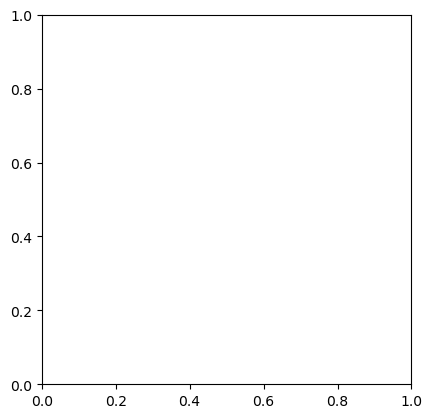

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a matrix named 'spike_matrix' with booleans
# Each row corresponds to a stimulus, and each column corresponds to a time bin

# Example data (replace this with your actual data)
spike_matrix = np.array(spike_array)

# Define the time range to exclude
exclude_start = int(0.49 * fSample) # i.e. 0.5 after start of peristim
exclude_end = int(0.71 * fSample)

# Set the spikes in the specified time range to False
# print(spike_matrix[:, exclude_start:exclude_end])
spike_matrix[:, exclude_start:exclude_end] = False

# Calculate the average spikes per time bin across all stimuli
average_spikes = np.mean(spike_matrix, axis=0)

# Plot the histogram
# plt.hist(average_spikes, bins=30, color='blue', alpha=0.7)
plt.imshow(average_spikes)
plt.title('Average Spikes per Time Bin')
plt.xlabel('Average Spikes')
plt.ylabel('Frequency')
# plt.ylim([0,0.25])

plt.show()


In [ ]:
x =[[0,0,1],
    [0,0,1],
    [0,0,1]]
y = np.mean(x, axis=2)
print(y)

AxisError: axis 2 is out of bounds for array of dimension 2

# Heatmap

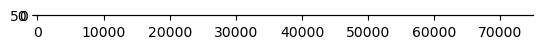

In [ ]:
plt.imshow(spike_array)
plt.show()

# Read recording with Moritz
1. Read in the xdat file for metadata and the binary file to spike sort
2. Get metadata and create probe mapping
3. CAR and Filter the signal
4. Save the filtered signal INTO THE RIGHT MAP
5. Kilosort
6. Extract waveforms
7. Postprocess

In [4]:
# Read in the xdat file for metadata and the binary file to spike sort
# Define the correct files 
root = "G:/NN_Recordings/NN_withCap/"
binFile = "G:/NN_Recordings/NN_withCap/curated/allego_0__uid0215-14-30-37_data.bin"
xdatFile = "G:/NN_Recordings/NN_withCap/raw/allego_0__uid0215-14-30-37"

# Get metadata and create probe mapping
metadata = afr.read_allego_xdat_metadata(xdatFile)
nChannel = metadata['sapiens_base']['sensors_by_port']['A']['num_channels']
fSample = metadata['status']['samp_freq']
probe = createProbe(metadata)
probe_df = probe.to_dataframe()

# Now we read in the binary file
raw_recording = si.read_binary(binFile, sampling_frequency=fSample, dtype='int16', num_channels=nChannel)
raw_recording.annotate(is_filtered=False)
raw_recording.set_probe(probe)
raw_recording.set_channel_locations(probe.contact_positions)

# Filter and save 
car_recording = spre.common_reference(raw_recording, reference='global', operator='average')
filt_recording = spre.bandpass_filter(car_recording, freq_min=300, freq_max=5000)
filt_recording.annotate(is_filtered=True)
filt_recording.save(folder="G:/NN_Recordings/NN_withCap/filtered/", overwrite=True)

# Kilosort
# Check if it is installed
if 'kilosort3' not in ss.installed_sorters():
    ss.Kilosort3Sorter.set_kilosort3_path('C:/Users/miksc/Kilosort/')
sorter_params = ss.get_default_sorter_params('kilosort3')
sorted_recording = ss.run_sorter('kilosort3', filt_recording, output_folder=root + 'results_KS3', verbose=True, remove_existing_folder=True,
                                     **sorter_params)

# Print some information about what Kilosort did
print('KS3 found', len(sorted_recording.get_unit_ids()), 'units')
# Remove empty units 
sorted_recording = sorted_recording.remove_empty_units()
print(f'KS3 found {len(sorted_recording.get_unit_ids())} non-empty units')

# Extract waveforms
we = si.extract_waveforms(filt_recording, sorted_recording, folder=root+'waveforms', load_if_exists=False, overwrite=True)#|, **job_kwargs) # Can set max_spikes_per_unit to None
sexp.export_to_phy(we, root+'phy')

# Quality metrics
metrics = si.qualitymetrics.compute_quality_metrics(we, metric_names=['firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'amplitude_cutoff'])
display(metrics)


write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 0/993 [00:00<?, ?it/s]

Setting KILOSORT3_PATH environment variable for subprocess calls to: C:\Users\miksc\Kilosort


write_binary_recording:   0%|          | 0/993 [00:00<?, ?it/s]

RUNNING SHELL SCRIPT: G:\NN_Recordings\NN_withCap\results_KS3\sorter_output\run_kilosort3.bat


(spikeinterface) c:\Users\miksc\OneDrive\coding_projects\spikeinterface>G:



(spikeinterface) G:\>cd G:\NN_Recordings\NN_withCap\results_KS3\sorter_output 



(spikeinterface) G:\NN_Recordings\NN_withCap\results_KS3\sorter_output>matlab -nosplash -wait -r "kilosort3_master('G:\NN_Recordings\NN_withCap\results_KS3\sorter_output', 'C:\Users\miksc\Kilosort')" 

kilosort3 run time 114.57s
KS3 found 31 units
KS3 found 31 non-empty units


extract waveforms shared_memory multi buffer:   0%|          | 0/993 [00:00<?, ?it/s]

Setting 'return_scaled' to False


extract waveforms memmap multi buffer:   0%|          | 0/993 [00:00<?, ?it/s]

write_binary_recording:   0%|          | 0/993 [00:00<?, ?it/s]

Setting 'return_scaled' to False


extract amplitudes:   0%|          | 0/993 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/31 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/31 [00:00<?, ?it/s]

extract PCs:   0%|          | 0/993 [00:00<?, ?it/s]

Run:
phy template-gui  G:\NN_Recordings\NN_withCap\phy\params.py


,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,amplitude_cutoff
0,0.259893,0.5000,3.452381,9.942479,2.0,NaN
1,0.810906,0.9375,3.152218,18.382935,36.0,0.028126
2,2.394439,1.0000,1.681859,1.347019,23.0,0.000681
3,0.135990,0.3125,9.159525,944.147665,52.0,NaN
4,2.041871,1.0000,1.656895,3.302026,41.0,0.001142
5,0.300186,0.4375,3.259648,22.357479,6.0,NaN
6,0.125917,0.8125,2.401783,21.177958,1.0,NaN
7,1.314574,1.0000,0.739838,4.274701,22.0,0.000939
8,0.100734,0.4375,3.491665,0.000000,0.0,NaN
9,0.153115,0.5000,3.566087,0.000000,0.0,NaN


In [27]:
# Curation using the metrics
# A common curation approach is to threshold these metrics to select good units. 
from phy.apps.template import template_gui
file = "G:/NN_Recordings/NN_withCap/manual/sorted/params.py"
# template_gui(root+'phy/params.py') 
template_gui(file)

In [13]:
%matplotlib widget
w = sw.plot_timeseries({"raw": raw_recording, "filt": filt_recording, "common": car_recording},
                        clim=(-50, 50), time_range=[80, 81.5], order_channel_by_depth=True, # TODO they are now ordered by depth, but this might be incorrect with remapper
                        backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…